# Spectral Reconstruction: ICVL

In [1]:
import pickle
from pathlib import Path

import h5py
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import PolynomialFeatures

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [2]:
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('bgr', ['blue', 'green', 'red'])

## Metrics

In [3]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2, axis=1))

def mrae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) / y_true, axis=1)

## Dataset

In [4]:
with open('resources/ICVL/train.txt', 'r') as file:
    images_train = [Path(f'datasets/ICVL/{it}') for it in file.read().splitlines()]

In [5]:
with open('resources/ICVL/test.txt', 'r') as file:
    images_test = [Path(f'datasets/ICVL/{it}') for it in file.read().splitlines()]

In [6]:
with open('resources/ICVL/val.txt', 'r') as file:
    images_val = [Path(f'datasets/ICVL/{it}') for it in file.read().splitlines()]

In [7]:
def load(path: Path):
    with h5py.File(path, 'r') as file:
        y = np.array(file['rad']) / 4095
        y = y.reshape(y.shape[0], -1).T

    X = np.load(path.with_suffix('.npy')) \
        .swapaxes(0, 1) \
        .reshape(-1, 3)

    return X, y

In [8]:
ref_path = Path('datasets/ICVL/Lehavim_0910-1627.mat')

with h5py.File(ref_path, 'r') as file:
    _, width, height = file['rad'].shape

In [9]:
wavelengths = np.arange(400, 700 + 1, 10)

## Least-Squares Regression

In [10]:
class RegressionLS:
    def __init__(self, n_features, n_channels):
        self._n_features = n_features
        self._n_channels = n_channels

        self._XX = np.zeros((self._n_features, self._n_features))
        self._XY = np.zeros((self._n_features, self._n_channels))

        self._M = np.zeros((self._n_features, self._n_channels))
        self.alpha_ = 0.0

    def update(self, X, y):
        self._XX += X.T @ X
        self._XY += X.T @ y

    def build(self, *, alpha=0.0):
        self._M = np.linalg.inv(self._XX + alpha * np.eye(self._n_features)) @ self._XY
        self.alpha_ = alpha

    def transform(self, X):
        return X @ self._M

### Linear Regression

In [11]:
lr_ls_path = Path('models/ICVL_LR_LS.pkl')

In [12]:
def train_lr_ls():
    model = RegressionLS(n_features=3, n_channels=len(wavelengths))

    print('Training:')
    for path in tqdm(images_train):
        X, y = load(path)
        model.update(X, y)
        del X, y

    alphas = np.logspace(-14, 5, num=20)
    total_sum = np.zeros_like(alphas)
    total_len = np.zeros_like(alphas)

    print('Validating:')
    for path in tqdm(images_val):
        X, y_true = load(path)

        for i, test_alpha in enumerate(alphas):
            model.build(alpha=test_alpha)
            y_pred = model.transform(X)

            total_sum[i] += mrae(y_true, y_pred).sum()
            total_len[i] += len(X)

            del y_pred

    alpha_costs = total_sum / total_len
    del X, y_true

    model.build(alpha=alphas[np.argmin(alpha_costs)])

    with open(lr_ls_path, 'wb') as file:
        pickle.dump(model, file, protocol=pickle.HIGHEST_PROTOCOL)

    return model

In [13]:
if lr_ls_path.exists():
    with open(lr_ls_path, 'rb') as file:
        model_lr_ls = pickle.load(file)
else:
    model_lr_ls = train_lr_ls()

In [14]:
lr_ls_mean_rmse_costs = []
lr_ls_mean_mrae_costs = []

for path in tqdm(images_test):
    X, y_true = load(path)
    y_pred = model_lr_ls.transform(X)

    lr_ls_mean_rmse_costs.append(np.mean(rmse(y_true, y_pred)))
    lr_ls_mean_mrae_costs.append(np.mean(mrae(y_true, y_pred)))

    del X, y_true, y_pred

100%|██████████| 20/20 [00:38<00:00,  1.92s/it]


In [15]:
lr_ls_df = pd.DataFrame({
    'Mean MRAE': lr_ls_mean_mrae_costs,
    'Mean RMSE': lr_ls_mean_rmse_costs,
}, index=images_test)

lr_ls_df.describe()

,Mean MRAE,Mean RMSE
count,20.000000,20.000000
mean,0.058601,0.007445
std,0.029599,0.002720
min,0.028909,0.003558
25%,0.033363,0.006021
50%,0.050103,0.007442
75%,0.073902,0.008037
max,0.132677,0.013369


In [16]:
X, y_true = load(ref_path)
y_pred = model_lr_ls.transform(X)

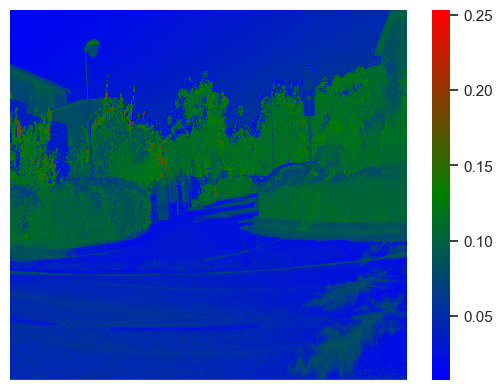

In [17]:
costs_lr_ls = mrae(y_true, y_pred)
costs_lr_ls = np.rot90(costs_lr_ls.reshape(width, height).swapaxes(0, 1))
sns.heatmap(costs_lr_ls, cmap=cmap)
plt.xticks([])
plt.yticks([])
plt.show()

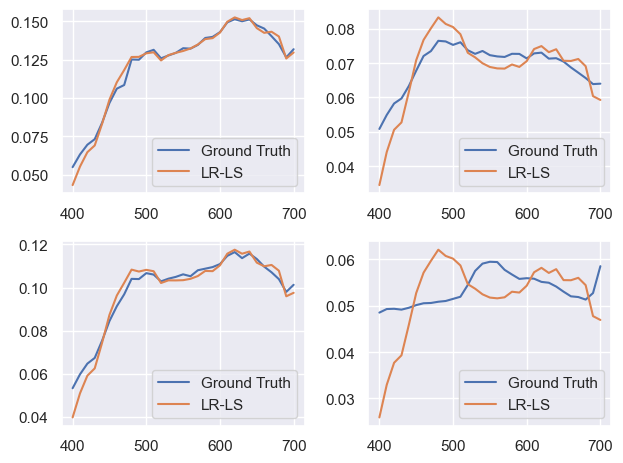

In [18]:
_, axes = plt.subplots(2, 2)

axes[0][0].plot(wavelengths, y_true[544118], label='Ground Truth')
axes[0][0].plot(wavelengths, y_pred[544118], label='LR-LS')
axes[0][0].legend()

axes[0][1].plot(wavelengths, y_true[635671], label='Ground Truth')
axes[0][1].plot(wavelengths, y_pred[635671], label='LR-LS')
axes[0][1].legend()

axes[1][0].plot(wavelengths, y_true[473949], label='Ground Truth')
axes[1][0].plot(wavelengths, y_pred[473949], label='LR-LS')
axes[1][0].legend()

axes[1][1].plot(wavelengths, y_true[1041754], label='Ground Truth')
axes[1][1].plot(wavelengths, y_pred[1041754], label='LR-LS')
axes[1][1].legend()

plt.tight_layout()
plt.show()

In [19]:
del X, y_true, y_pred

### Polynomial Regression

In [20]:
pr_ls_path = Path('models/ICVL_PR_LS.pkl')

In [21]:
def train_pr_ls():
    model = RegressionLS(n_features=83, n_channels=len(wavelengths))

    print('Training:')
    for path in tqdm(images_train):
        X, y = load(path)
        X = PolynomialFeatures(6, include_bias=False).fit_transform(X)
        model.update(X, y)
        del X, y

    alphas = np.logspace(-12, 2, num=15)
    total_sum = np.zeros_like(alphas)
    total_len = np.zeros_like(alphas)

    print('Validating:')
    for path in tqdm(images_val):
        X, y_true = load(path)
        X = PolynomialFeatures(6, include_bias=False).fit_transform(X)

        for i, test_alpha in enumerate(alphas):
            model.build(alpha=test_alpha)
            y_pred = model.transform(X)

            total_sum[i] += mrae(y_true, y_pred).sum()
            total_len[i] += len(X)

            del y_pred

    alpha_costs = total_sum / total_len
    del X, y_true

    model.build(alpha=alphas[np.argmin(alpha_costs)])

    with open(lr_ls_path, 'wb') as file:
        pickle.dump(model, file, protocol=pickle.HIGHEST_PROTOCOL)

    return model

In [22]:
if pr_ls_path.exists():
    with open(pr_ls_path, 'rb') as file:
        model_pr_ls = pickle.load(file)
else:
    model_pr_ls = train_pr_ls()

In [23]:
pr_ls_mean_rmse_costs = []
pr_ls_mean_mrae_costs = []

for path in tqdm(images_test):
    X, y_true = load(path)
    X = PolynomialFeatures(6, include_bias=False).fit_transform(X)

    y_pred = model_pr_ls.transform(X)

    pr_ls_mean_rmse_costs.append(np.mean(rmse(y_true, y_pred)))
    pr_ls_mean_mrae_costs.append(np.mean(mrae(y_true, y_pred)))

    del X, y_true, y_pred

100%|██████████| 20/20 [00:59<00:00,  2.96s/it]


In [24]:
pr_ls_df = pd.DataFrame({
    'Mean MRAE': pr_ls_mean_rmse_costs,
    'Mean RMSE': pr_ls_mean_mrae_costs,
}, index=images_test)

pr_ls_df.describe()

,Mean MRAE,Mean RMSE
count,20.000000,20.000000
mean,0.003760,0.018678
std,0.002110,0.008483
min,0.001243,0.008475
25%,0.002208,0.015069
50%,0.003597,0.017117
75%,0.004718,0.020348
max,0.010652,0.048648


In [25]:
X, y_true = load(ref_path)
X = PolynomialFeatures(6, include_bias=False).fit_transform(X)
y_pred = model_pr_ls.transform(X)

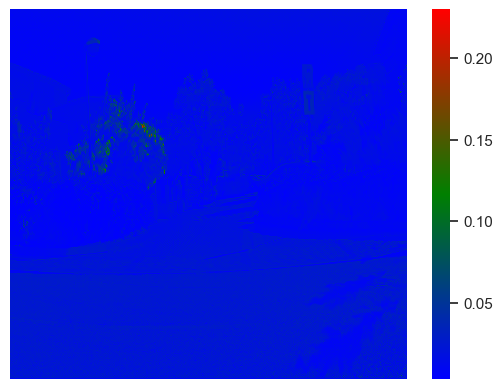

In [26]:
costs_pr_ls = mrae(y_true, y_pred)
costs_pr_ls = np.rot90(costs_pr_ls.reshape(width, height).swapaxes(0, 1))
sns.heatmap(costs_pr_ls, cmap=cmap)
plt.xticks([])
plt.yticks([])
plt.show()

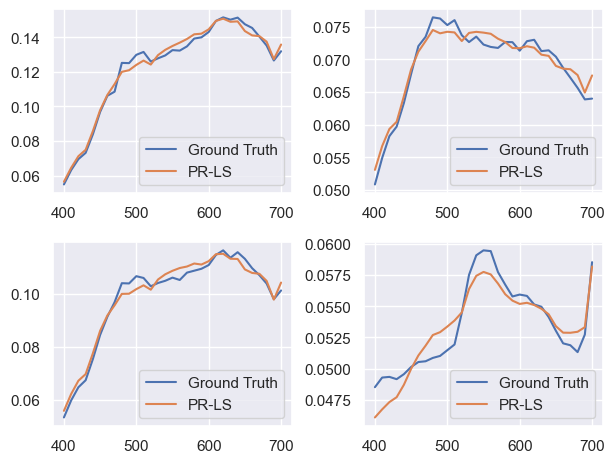

In [27]:
_, axes = plt.subplots(2, 2)

axes[0][0].plot(wavelengths, y_true[544118], label='Ground Truth')
axes[0][0].plot(wavelengths, y_pred[544118], label='PR-LS')
axes[0][0].legend()

axes[0][1].plot(wavelengths, y_true[635671], label='Ground Truth')
axes[0][1].plot(wavelengths, y_pred[635671], label='PR-LS')
axes[0][1].legend()

axes[1][0].plot(wavelengths, y_true[473949], label='Ground Truth')
axes[1][0].plot(wavelengths, y_pred[473949], label='PR-LS')
axes[1][0].legend()

axes[1][1].plot(wavelengths, y_true[1041754], label='Ground Truth')
axes[1][1].plot(wavelengths, y_pred[1041754], label='PR-LS')
axes[1][1].legend()

plt.tight_layout()
plt.show()

In [28]:
del X, y_true, y_pred

## RELS

In [29]:
class RegressionRELS:
    def __init__(self, n_features, n_channels):
        self.n_features_ = n_features
        self.n_channels_ = n_channels

        self._XX = [np.zeros((n_features, n_features)) for _ in range(n_channels)]
        self._XY = np.zeros((n_features, n_channels))

        self._M = np.zeros((n_features, n_channels))
        self.alphas_ = np.zeros(n_channels)

    def build_channel(self, *, channel: int, alpha: float):
        self._M[:, channel] = np.linalg.inv(self._XX[channel] + alpha * np.eye(self.n_features_)) @ self._XY[:, channel]
        self.alphas_[channel] = alpha

    def update(self, X, y):
        n = X.shape[0]

        for channel in range(self.n_channels_):
            H = 1.0 / y[:, channel].reshape(n, 1) * X

            self._XX[channel] += H.T @ H
            self._XY[:, channel] += H.T @ np.ones(n)

    def transform(self, X):
        return X @ self._M

    def transform_channel(self, X, *, channel: int):
        return X @ self._M[:, channel].reshape(-1, 1)

### Linear Regression

In [30]:
lr_rels_path = Path('models/ICVL_LR_RELS.pkl')

In [31]:
def train_lr_rels():
    model = RegressionRELS(n_features=3, n_channels=len(wavelengths))

    print('Training:')
    for path in tqdm(images_train):
        X, y = load(path)
        model.update(X, y)
        del X, y

    alphas = np.logspace(-30, 10, num=41)
    total_sum = np.zeros_like(alphas)
    total_len = np.zeros_like(alphas)

    print('Validating:')
    for path in tqdm(images_val):
        X, y_true = load(path)

        for channel in range(model.n_channels_):
            for i, test_alpha in enumerate(alphas):
                model.build_channel(channel=channel, alpha=test_alpha)
                y_pred = model.transform(X)

                total_sum[i] += mrae(y_true, y_pred).sum()
                total_len[i] += len(X)

                del y_pred

    alpha_costs = total_sum / total_len
    del X, y_true

    for channel in range(model.n_channels_):
        best_alpha = np.argmin(alpha_costs[channel, :])
        model.build_channel(channel=channel, alpha=best_alpha)

    with open(lr_rels_path, 'wb') as file:
        pickle.dump(model, file, protocol=pickle.HIGHEST_PROTOCOL)

    return model

In [32]:
if lr_rels_path.exists():
    with open(lr_rels_path, 'rb') as file:
        model_lr_rels = pickle.load(file)
else:
    model_lr_rels = train_lr_rels()

In [33]:
lr_rels_mean_rmse_costs = []
lr_rels_mean_mrae_costs = []

for path in tqdm(images_test):
    X, y_true = load(path)
    y_pred = model_lr_rels.transform(X)

    lr_rels_mean_rmse_costs.append(np.mean(rmse(y_true, y_pred)))
    lr_rels_mean_mrae_costs.append(np.mean(mrae(y_true, y_pred)))

    del X, y_true, y_pred

100%|██████████| 20/20 [00:38<00:00,  1.91s/it]


In [34]:
lr_rels_df = pd.DataFrame({
    'Mean MRAE': lr_rels_mean_mrae_costs,
    'Mean RMSE': lr_rels_mean_rmse_costs,
}, index=images_test)

lr_rels_df.describe()

,Mean MRAE,Mean RMSE
count,20.000000,20.000000
mean,0.053815,0.008982
std,0.017478,0.004238
min,0.029907,0.004351
25%,0.044091,0.006986
50%,0.052074,0.008234
75%,0.061825,0.009573
max,0.097718,0.021944


In [35]:
X, y_true = load(ref_path)
y_pred = model_lr_rels.transform(X)

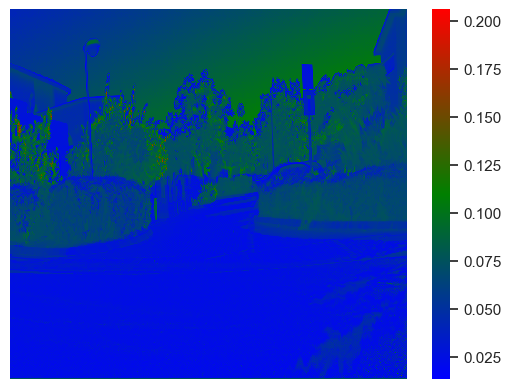

In [36]:
costs_lr_rels = mrae(y_true, y_pred)
costs_lr_rels = np.rot90(costs_lr_rels.reshape(width, height).swapaxes(0, 1))
sns.heatmap(costs_lr_rels, cmap=cmap)
plt.xticks([])
plt.yticks([])
plt.show()

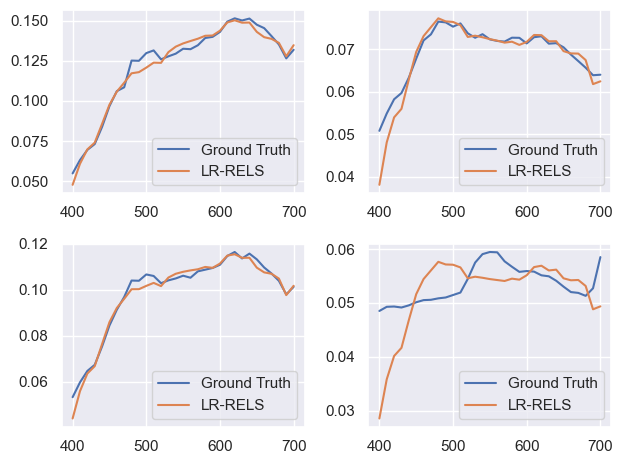

In [37]:
_, axes = plt.subplots(2, 2)

axes[0][0].plot(wavelengths, y_true[544118], label='Ground Truth')
axes[0][0].plot(wavelengths, y_pred[544118], label='LR-RELS')
axes[0][0].legend()

axes[0][1].plot(wavelengths, y_true[635671], label='Ground Truth')
axes[0][1].plot(wavelengths, y_pred[635671], label='LR-RELS')
axes[0][1].legend()

axes[1][0].plot(wavelengths, y_true[473949], label='Ground Truth')
axes[1][0].plot(wavelengths, y_pred[473949], label='LR-RELS')
axes[1][0].legend()

axes[1][1].plot(wavelengths, y_true[1041754], label='Ground Truth')
axes[1][1].plot(wavelengths, y_pred[1041754], label='LR-RELS')
axes[1][1].legend()

plt.tight_layout()
plt.show()

In [38]:
del X, y_true, y_pred

### Polynomial Regression

In [39]:
pr_rels_path = Path('models/ICVL_PR_RELS.pkl')

In [40]:
def train_pr_rels():
    model = RegressionRELS(n_features=83, n_channels=len(wavelengths))

    print('Training:')
    for path in tqdm(images_train):
        X, y = load(path)
        X = PolynomialFeatures(6, include_bias=False).fit_transform(X)
        model.update(X, y)
        del X, y

    alphas = np.logspace(-15, 5, num=21)
    total_sum = np.zeros_like(alphas)
    total_len = np.zeros_like(alphas)

    print('Validating:')
    for path in tqdm(images_val):
        X, y_true = load(path)
        X = PolynomialFeatures(6, include_bias=False).fit_transform(X)

        for channel in range(model.n_channels_):
            for i, test_alpha in enumerate(alphas):
                model.build_channel(channel=channel, alpha=test_alpha)
                y_pred = model.transform(X)

                total_sum[i] += mrae(y_true, y_pred).sum()
                total_len[i] += len(X)

                del y_pred

    alpha_costs = total_sum / total_len
    del X, y_true

    for channel in range(model.n_channels_):
        best_alpha = np.argmin(alpha_costs[channel, :])
        model.build_channel(channel=channel, alpha=best_alpha)

    with open(lr_rels_path, 'wb') as file:
        pickle.dump(model, file, protocol=pickle.HIGHEST_PROTOCOL)

    return model

In [41]:
if pr_rels_path.exists():
    with open(pr_rels_path, 'rb') as file:
        model_pr_rels = pickle.load(file)
else:
    model_pr_rels = train_pr_rels()

In [42]:
pr_rels_mean_rmse_costs = []
pr_rels_mean_mrae_costs = []

for path in tqdm(images_test):
    X, y_true = load(path)
    X = PolynomialFeatures(6, include_bias=False).fit_transform(X)

    y_pred = model_pr_rels.transform(X)

    pr_rels_mean_rmse_costs.append(np.mean(rmse(y_true, y_pred)))
    pr_rels_mean_mrae_costs.append(np.mean(mrae(y_true, y_pred)))

    del X, y_true, y_pred

100%|██████████| 20/20 [00:59<00:00,  2.99s/it]


In [43]:
pr_rels_df = pd.DataFrame({
    'Mean MRAE': pr_rels_mean_mrae_costs,
    'Mean RMSE': pr_rels_mean_rmse_costs,
}, index=images_test)

pr_rels_df.describe()

,Mean MRAE,Mean RMSE
count,20.000000,20.000000
mean,0.020331,0.004336
std,0.006778,0.002470
min,0.011012,0.001624
25%,0.017414,0.002666
50%,0.019219,0.003694
75%,0.021858,0.005315
max,0.042870,0.012214


In [44]:
X, y_true = load(ref_path)
X = PolynomialFeatures(6, include_bias=False).fit_transform(X)
y_pred = model_pr_rels.transform(X)

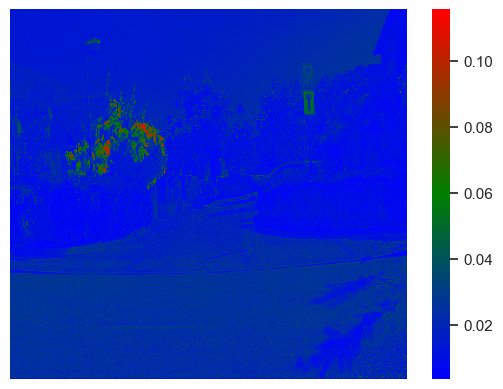

In [45]:
costs_pr_rels = mrae(y_true, y_pred)
costs_pr_rels = np.rot90(costs_pr_rels.reshape(width, height).swapaxes(0, 1))
sns.heatmap(costs_pr_rels, cmap=cmap)
plt.xticks([])
plt.yticks([])
plt.show()

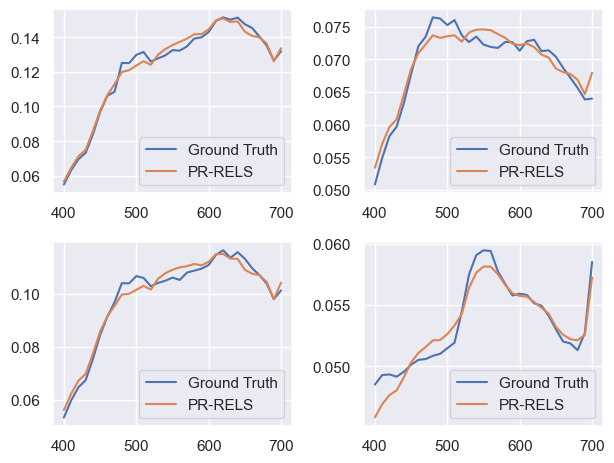

In [46]:
_, axes = plt.subplots(2, 2)

axes[0][0].plot(wavelengths, y_true[544118], label='Ground Truth')
axes[0][0].plot(wavelengths, y_pred[544118], label='PR-RELS')
axes[0][0].legend()

axes[0][1].plot(wavelengths, y_true[635671], label='Ground Truth')
axes[0][1].plot(wavelengths, y_pred[635671], label='PR-RELS')
axes[0][1].legend()

axes[1][0].plot(wavelengths, y_true[473949], label='Ground Truth')
axes[1][0].plot(wavelengths, y_pred[473949], label='PR-RELS')
axes[1][0].legend()

axes[1][1].plot(wavelengths, y_true[1041754], label='Ground Truth')
axes[1][1].plot(wavelengths, y_pred[1041754], label='PR-RELS')
axes[1][1].legend()

plt.tight_layout()
plt.show()

In [47]:
del X, y_true, y_pred

## Comparison

In [48]:
costs = [costs_lr_ls, costs_pr_ls, costs_lr_rels, costs_pr_rels]
vmin = min(cost.min() for cost in costs)
vmax = max(cost.max() for cost in costs)

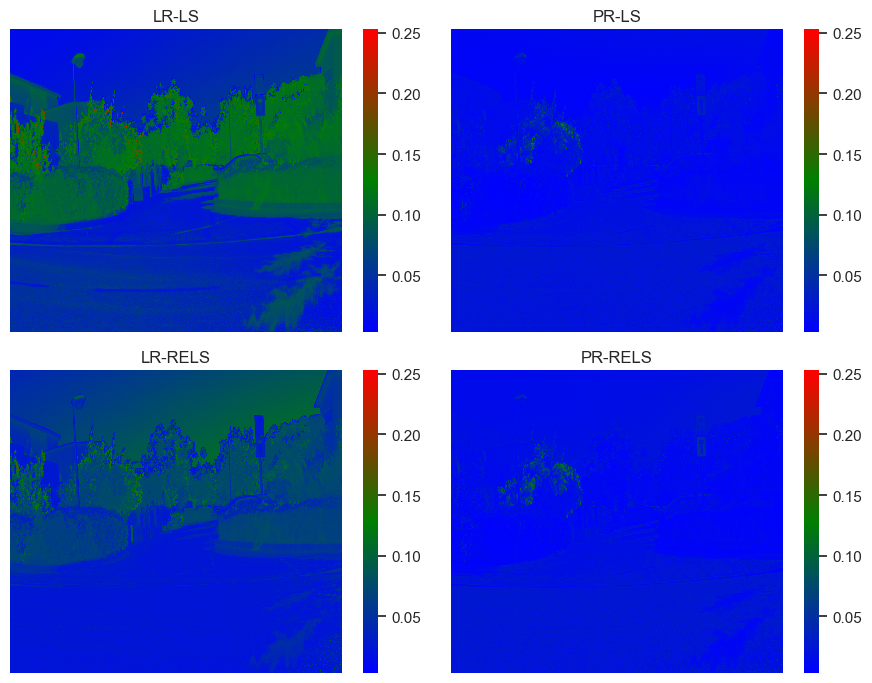

In [49]:
_, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 7))

sns.heatmap(costs_lr_ls, cmap=cmap, ax=axes[0, 0], vmin=vmin, vmax=vmax)
axes[0, 0].set_title('LR-LS')
axes[0, 0].set_xticks([])
axes[0, 0].set_yticks([])

sns.heatmap(costs_pr_ls, cmap=cmap, ax=axes[0, 1], vmin=vmin, vmax=vmax)
axes[0, 1].set_title('PR-LS')
axes[0, 1].set_xticks([])
axes[0, 1].set_yticks([])

sns.heatmap(costs_lr_rels, cmap=cmap, ax=axes[1, 0], vmin=vmin, vmax=vmax)
axes[1, 0].set_title('LR-RELS')
axes[1, 0].set_xticks([])
axes[1, 0].set_yticks([])

sns.heatmap(costs_pr_rels, cmap=cmap, ax=axes[1, 1], vmin=vmin, vmax=vmax)
axes[1, 1].set_title('PR-RELS')
axes[1, 1].set_xticks([])
axes[1, 1].set_yticks([])

plt.tight_layout()
plt.show()